In [4]:
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import os
import pandas as pd

In [5]:
def read_file(file_name):
    # Get current working directory and go up one level (from src to project root)
    current_dir = os.getcwd()
    base_dir = os.path.dirname(current_dir)
    target_path = os.path.join(base_dir, file_name)    

    file_contents = ""
    data = []

    try:
        with open(target_path) as f:
            file_contents = f.readlines()

        for line in file_contents:
            data.append(tuple(map(int, (line.split()))))

        return data
    except FileNotFoundError:
        print(f"File not found: {target_path}")
        return None


def get_item_att(items, ind):
    value = 0
    weight = 0

    for i, att in enumerate(ind):
        if(att == 1):
           (value_ind, weight_ind) = items[i]
           value += value_ind
           weight += weight_ind 

    return (value, weight)

In [6]:
main_dic = os.getcwd()
knapsack_10 = "data/knapsack-data_2/10_269"

data = read_file(knapsack_10)


In [7]:
def calc_fitness(max_weight, items, ind):
    value = 0
    weight = 0

    for i, att in enumerate(ind):
        if att == 1:
            value_ind, weight_ind = items[i]
            value += value_ind
            weight += weight_ind

    if weight > max_weight:
        # Penalty proportional to how overweight it is
        penalty = ((weight - max_weight) / max_weight) * value
        fitness = value - penalty
        # Ensure fitness is negative if overweight
        if fitness > 0:
            fitness = -fitness
        # print(f"Weight: {weight} | Fitness: {fitness}")
        return fitness
    else:
        return value


In [ ]:
def EDA(items, item_size, max_weight, pop_size=200, gens=100, 
        Nbest=8, Nworst=6, pmin=0.05, pmax=0.95, eta=0.01, seed=1000):
    
    np.random.seed(seed)

    prob = np.full(item_size, 0.5)

    best_solution, best_value = None, 0
    gen_best_values = [] 
    gen_best_solutions = []

    for g in range(gens):

        # Set population if iniduals with random values
        population = (np.random.rand(pop_size, item_size) < prob).astype(int)

        # Obtain the fitness
        fitness = np.array([calc_fitness(max_weight, items, ind) for ind in population])

        # Sort the indivudals by fitness
        sorted_idx = np.argsort(fitness)
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]

        # For loging 
        gen_best_values.append(fitness[-1])
        gen_best_solutions.append(population[-1])

        # Changes the best fitness
        if fitness[-1] > best_value:
            best_value = fitness[-1]
            best_solution = population[-1]

        # For I best ind adjust
        for i in range(Nbest):  
            xi = population[-(i+1)]
            prob = prob + eta * (xi - prob)

        for i in range(Nworst): 
            xi = population[i]
            prob = prob - eta * (xi - prob)

        prob = np.clip(prob, pmin, pmax)

        print(f"Gen {g+1}: Gen best = {fitness[-1]}, Overall best = {best_value}")

    return best_solution, best_value, gen_best_solutions, gen_best_values



In [ ]:

def run_with_seed(items, seeds = [500,1000,1500, 2000, 2500]):

    (num_items, bag_cap)= items.pop(0)

    seed_res = []

    for seed in seeds:
        (best_solution, best_value, gen_best_solutions, gen_best_values) = EDA(items, num_items, bag_cap, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": gen_best_values
        })

        
    return seed_res
        


def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def table_and_avg_plot(seed_res, title=""):

    final_bests = []
    all_best_values = []

    # --- Collect per-seed results ---
    for res in seed_res:
        seed = res['seed']
        best_values = res['best_values']
        final_bests.append(best_values[-1])
        all_best_values.append(best_values)

    # --- Average over seeds ---
    # Pad shorter runs with NaN if seeds have different lengths
    max_len = max(len(v) for v in all_best_values)
    arr = np.full((len(all_best_values), max_len), np.nan)
    for i, v in enumerate(all_best_values):
        arr[i, :len(v)] = v
    
    mean_over_gens = np.nanmean(arr, axis=0)
    std_over_gens = np.nanstd(arr, axis=0)

    # --- Plot only average curve ---
    plt.figure(figsize=(8,5))
    gens = np.arange(1, len(mean_over_gens)+1)
    plt.plot(gens, mean_over_gens, label="Mean Best Fitness")
    plt.fill_between(gens,
                     mean_over_gens - std_over_gens,
                     mean_over_gens + std_over_gens,
                     alpha=0.3, label="±1 Std Dev")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title(f"Average Best Fitness Across Seeds: {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Create table with best individuals ---
    df = pd.DataFrame({
        'Seed': [res['seed'] for res in seed_res],
        'Best Individual': final_bests
    })

    # Append mean and std at the bottom
    summary_row = pd.DataFrame({
        'Seed': ['Mean', 'Std'],
        'Best Individual': [np.mean(final_bests), np.std(final_bests)]
    })

    final_table = pd.concat([df, summary_row], ignore_index=True)
    return final_table


In [11]:
items_269 = read_file("data/knapsack-data_2/10_269")
items_10000 = read_file("data/knapsack-data_2/23_10000")
items_995 = read_file("data/knapsack-data_2/100_995")

[0 1 1 0 0 1 0 1 1 0]
[0 1 0 0 0 0 0 1 1 1]
[0 0 0 1 0 0 0 1 1 1]
[1 1 0 0 0 0 0 0 1 1]
[0 0 0 1 1 1 0 0 1 1]
[0 0 1 0 0 0 1 0 1 1]
[1 0 0 0 0 0 0 0 1 1]
[1 1 0 1 1 0 0 1 0 1]
Gen 1: Gen best = 253.0, Overall best = 253.0
[0 1 1 1 0 0 0 1 1 1]
[0 0 0 1 1 0 0 1 1 1]
[0 1 0 0 0 1 1 0 1 1]
[0 0 0 0 0 0 0 1 1 1]
[1 0 0 0 1 0 0 0 1 1]
[0 1 1 0 0 0 0 0 1 1]
[0 1 1 0 0 0 0 0 1 1]
[0 0 1 1 1 0 0 0 1 1]
Gen 2: Gen best = 295.0, Overall best = 295.0
[0 1 1 0 1 0 0 1 1 1]
[0 1 1 0 1 0 0 1 1 1]
[0 0 1 0 0 1 0 0 1 1]
[0 0 1 0 0 1 0 0 1 1]
[0 0 1 0 0 1 0 1 0 1]
[0 1 0 0 0 0 0 1 1 1]
[1 1 0 1 0 0 0 0 1 1]
[0 1 0 0 0 1 1 0 1 1]
Gen 3: Gen best = 294.0, Overall best = 295.0
[1 0 1 0 0 0 0 0 1 1]
[0 1 0 1 1 0 0 1 1 1]
[0 1 0 0 0 0 1 1 1 1]
[1 0 1 0 0 0 0 1 0 1]
[0 1 0 1 0 0 0 1 1 1]
[1 1 0 0 1 0 0 0 1 1]
[0 0 0 0 1 0 0 1 1 1]
[1 0 0 1 0 0 0 0 1 1]
Gen 4: Gen best = 274.0, Overall best = 295.0
[0 1 1 1 0 0 0 1 1 1]
[0 1 0 0 0 1 0 1 1 1]
[0 1 1 0 0 1 0 0 1 1]
[0 0 1 0 1 1 0 0 1 1]
[0 1 0 0 1 0 0 1 1 1]
[0

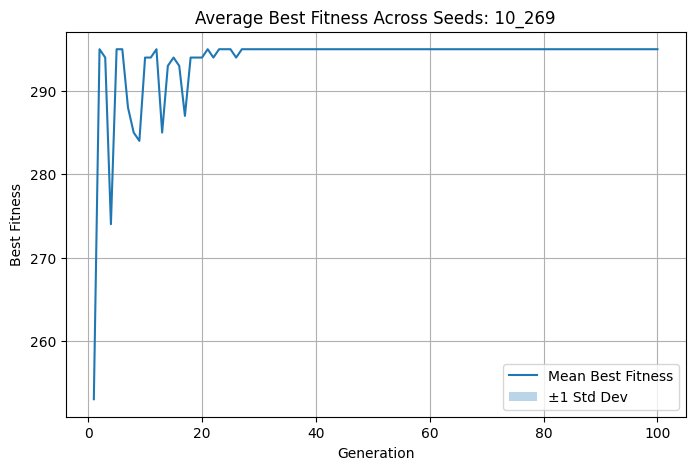

,Seed,Best Individual
0,500,295.0
1,Mean,295.0
2,Std,0.0


In [12]:
seed_res_269 = run_with_seed(items_269)
table_and_avg_plot(seed_res_269, title="10_269")

[1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0]
[1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0]
[1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0]
[1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0]
[0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0]
[0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0]
[0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0]
[1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0]
Gen 1: Gen best = 9747.0, Overall best = 9747.0
[1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0]
[1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0]
[1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0]
[1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0]
[0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0]
[1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1]
[1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1]
[0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1]
Gen 2: Gen best = 9730.0, Overall best = 9747.0
[0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0]
[1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0]
[0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1

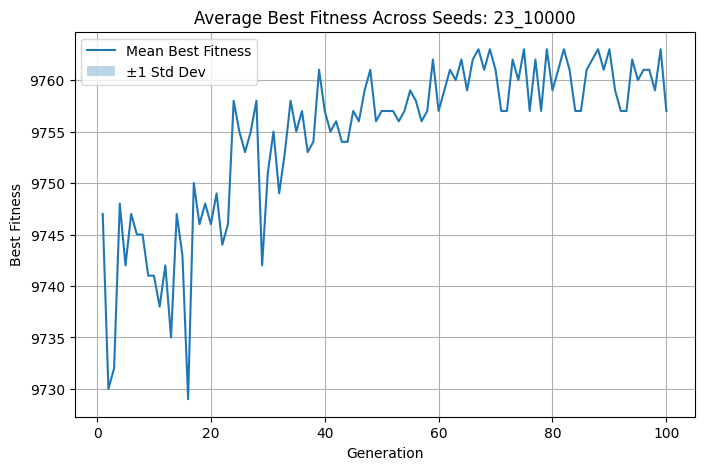

,Seed,Best Individual
0,500,9757.0
1,Mean,9757.0
2,Std,0.0


In [13]:
seed_res_10000 = run_with_seed(items_10000)
table_and_avg_plot(seed_res_10000, title="23_10000")

In [14]:
seed_res_10000 = run_with_seed(items_10000)
table_and_avg_plot(seed_res_10000, title="23_10000")

IndexError: list index out of range

Gen 1: Gen best = -260453.94874371856, Overall best = 0
Gen 2: Gen best = -226904.03819095477, Overall best = 0
Gen 3: Gen best = -196113.42211055275, Overall best = 0
Gen 4: Gen best = -177990.7798994975, Overall best = 0
Gen 5: Gen best = -201944.6834170854, Overall best = 0
Gen 6: Gen best = -180447.82613065327, Overall best = 0
Gen 7: Gen best = -102275.71457286432, Overall best = 0
Gen 8: Gen best = -131087.19396984924, Overall best = 0
Gen 9: Gen best = -112053.98994974873, Overall best = 0
Gen 10: Gen best = -84870.92261306533, Overall best = 0
Gen 11: Gen best = -91686.01407035175, Overall best = 0
Gen 12: Gen best = -36932.886432160805, Overall best = 0
Gen 13: Gen best = -43692.340703517584, Overall best = 0
Gen 14: Gen best = -38297.48743718593, Overall best = 0
Gen 15: Gen best = -46561.051256281404, Overall best = 0
Gen 16: Gen best = -29084.044221105527, Overall best = 0
Gen 17: Gen best = -25921.843216080404, Overall best = 0
Gen 18: Gen best = -16330.043216080401, Overa

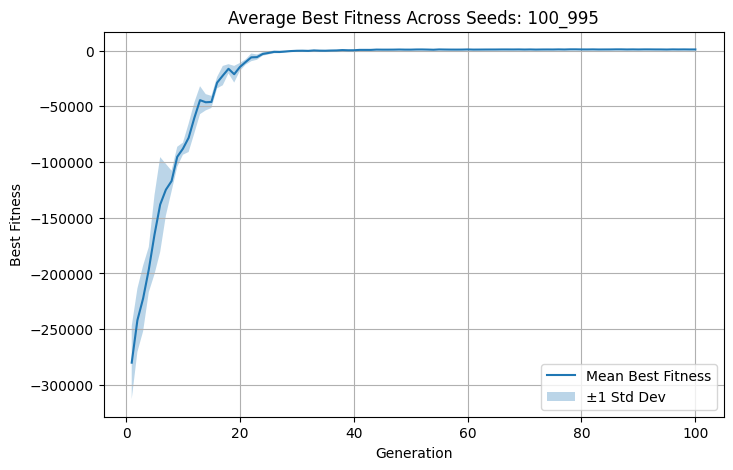

,Seed,Best Individual
0,500,987.000000
1,1000,1161.000000
2,1500,912.000000
3,2000,1069.000000
4,2500,1000.000000
5,Mean,1025.800000
6,Std,83.984284


In [ ]:
seed_res_995 = run_with_seed(items_995)
table_and_avg_plot(seed_res_995, title="100_995")


